# 

In [1]:
# General Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers  import MaxPooling2D, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomZoom, RandomContrast

# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint




# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

2025-08-08 01:53:53.549112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754618033.747799      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754618033.801556      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Processing**

In [2]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [3]:
# Getting data labels

train_paths, train_index = get_data_labels('/kaggle/input/brain-tumor-dataset/Training', random_state=111)
test_paths, test_index = get_data_labels('/kaggle/input/brain-tumor-dataset/Testing', random_state=111)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

# Prepare datasets with 4 classes and grayscale
batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

# Output to show datasets
print(f"\nTraining dataset: {train_ds}")
print(f"\nTesting dataset: {test_ds}")

# Class mappings
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311

Training dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 168, 168, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


I0000 00:00:1754618045.694841      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# **Data Visualization**

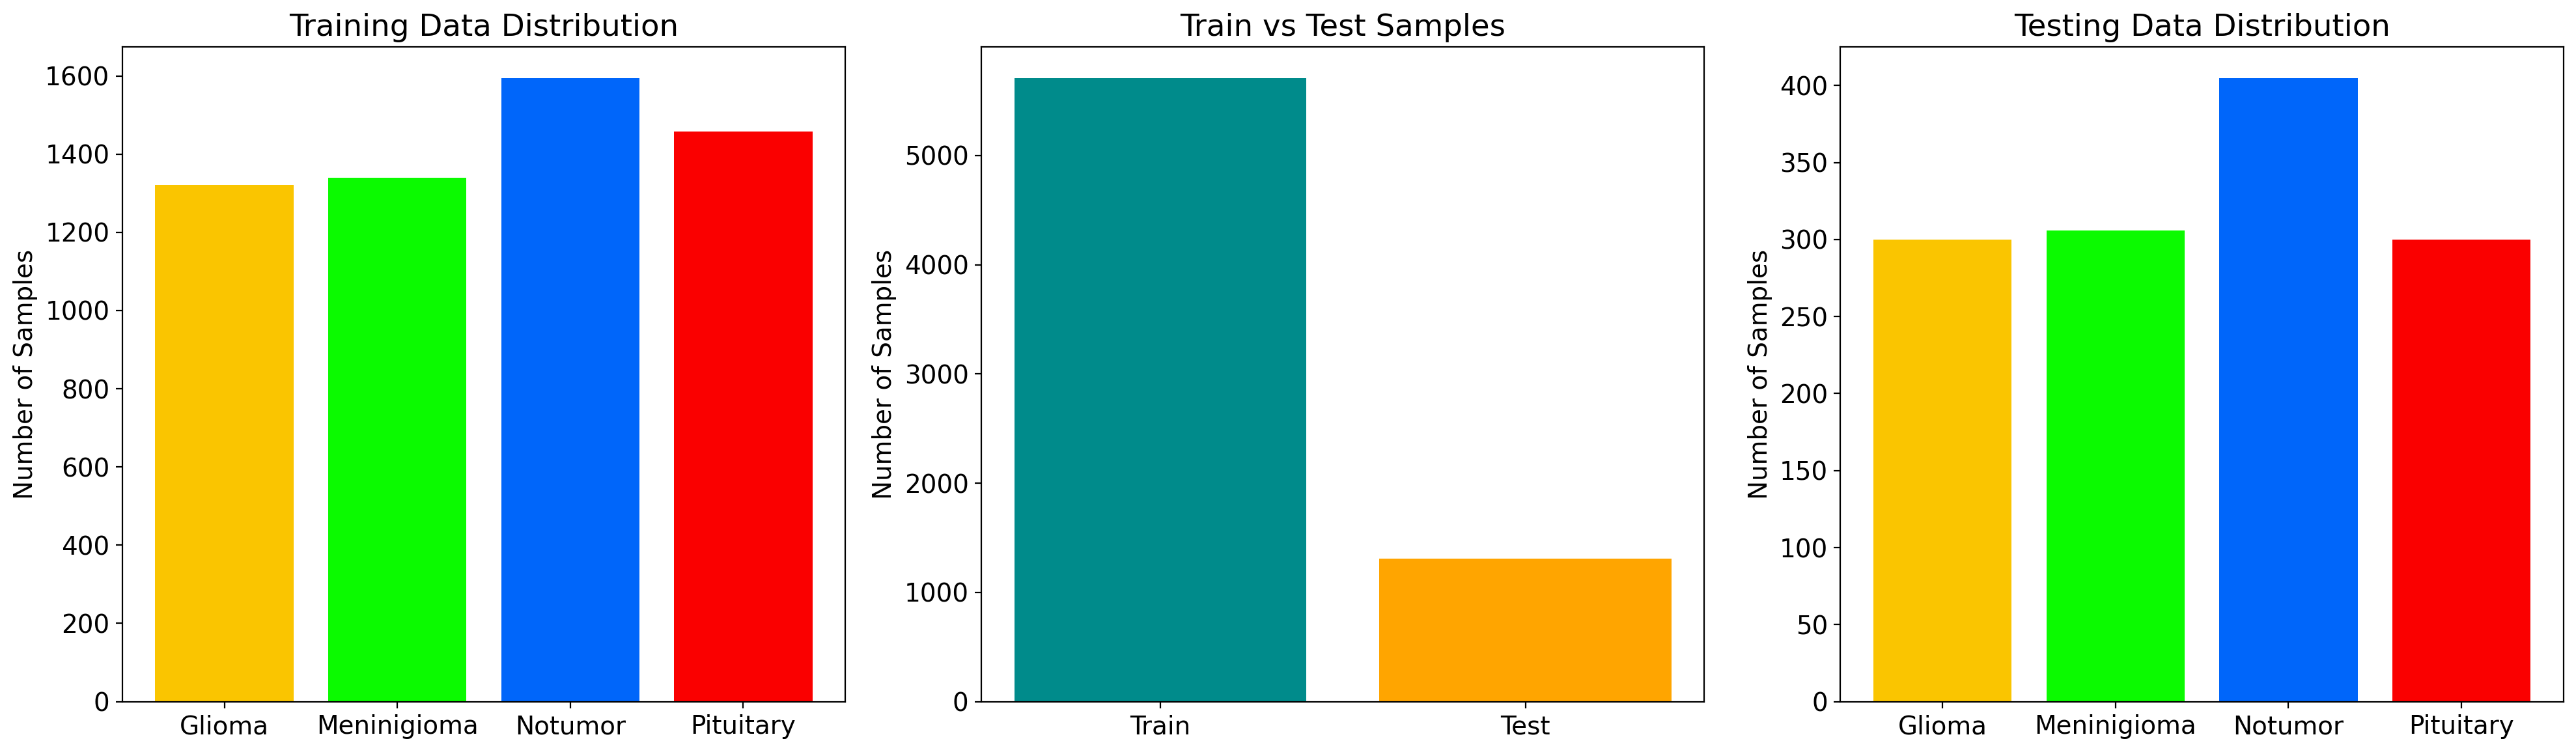

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Training data distribution
train_counts = [sum(1 for x in train_index if x == i) for i in range(len(class_names))]
ax[0].bar(class_names, train_counts, color=['#FAC500','#0BFA00','#0066FA','#FA0000'])
ax[0].set_title("Training Data Distribution")
ax[0].set_ylabel("Number of Samples")

# Train/Test split
ax[1].bar(['Train', 'Test'], [len(train_index), len(test_index)], color=['darkcyan', 'orange'])
ax[1].set_title("Train vs Test Samples")
ax[1].set_ylabel("Number of Samples")

# Testing data distribution
test_counts = [sum(1 for x in test_index if x == i) for i in range(len(class_names))]
ax[2].bar(class_names, test_counts, color=['#FAC500','#0BFA00','#0066FA','#FA0000'])
ax[2].set_title("Testing Data Distribution")
ax[2].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()


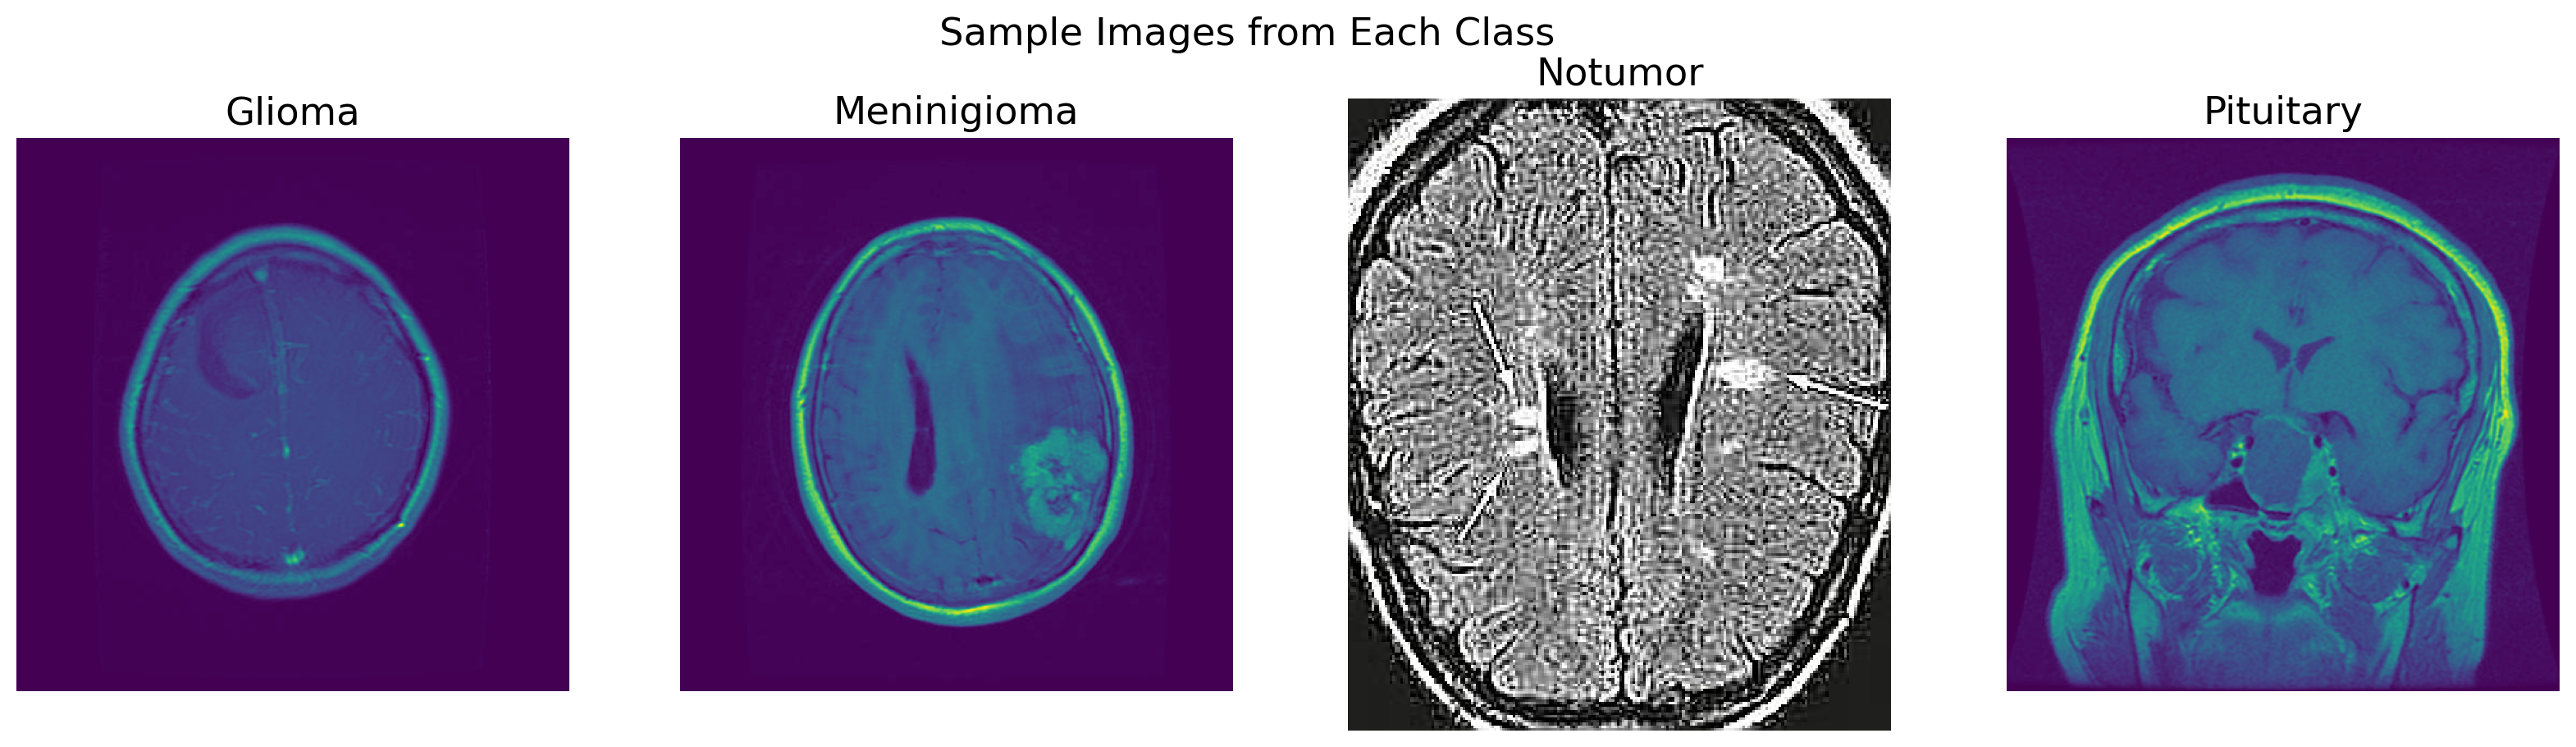

In [5]:
import random
from PIL import Image

fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))
for i, cls in enumerate(class_names):
    sample_path = random.choice([p for p, label in zip(train_paths, train_index) if label == i])
    img = Image.open(sample_path)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.suptitle("Sample Images from Each Class")
plt.show()


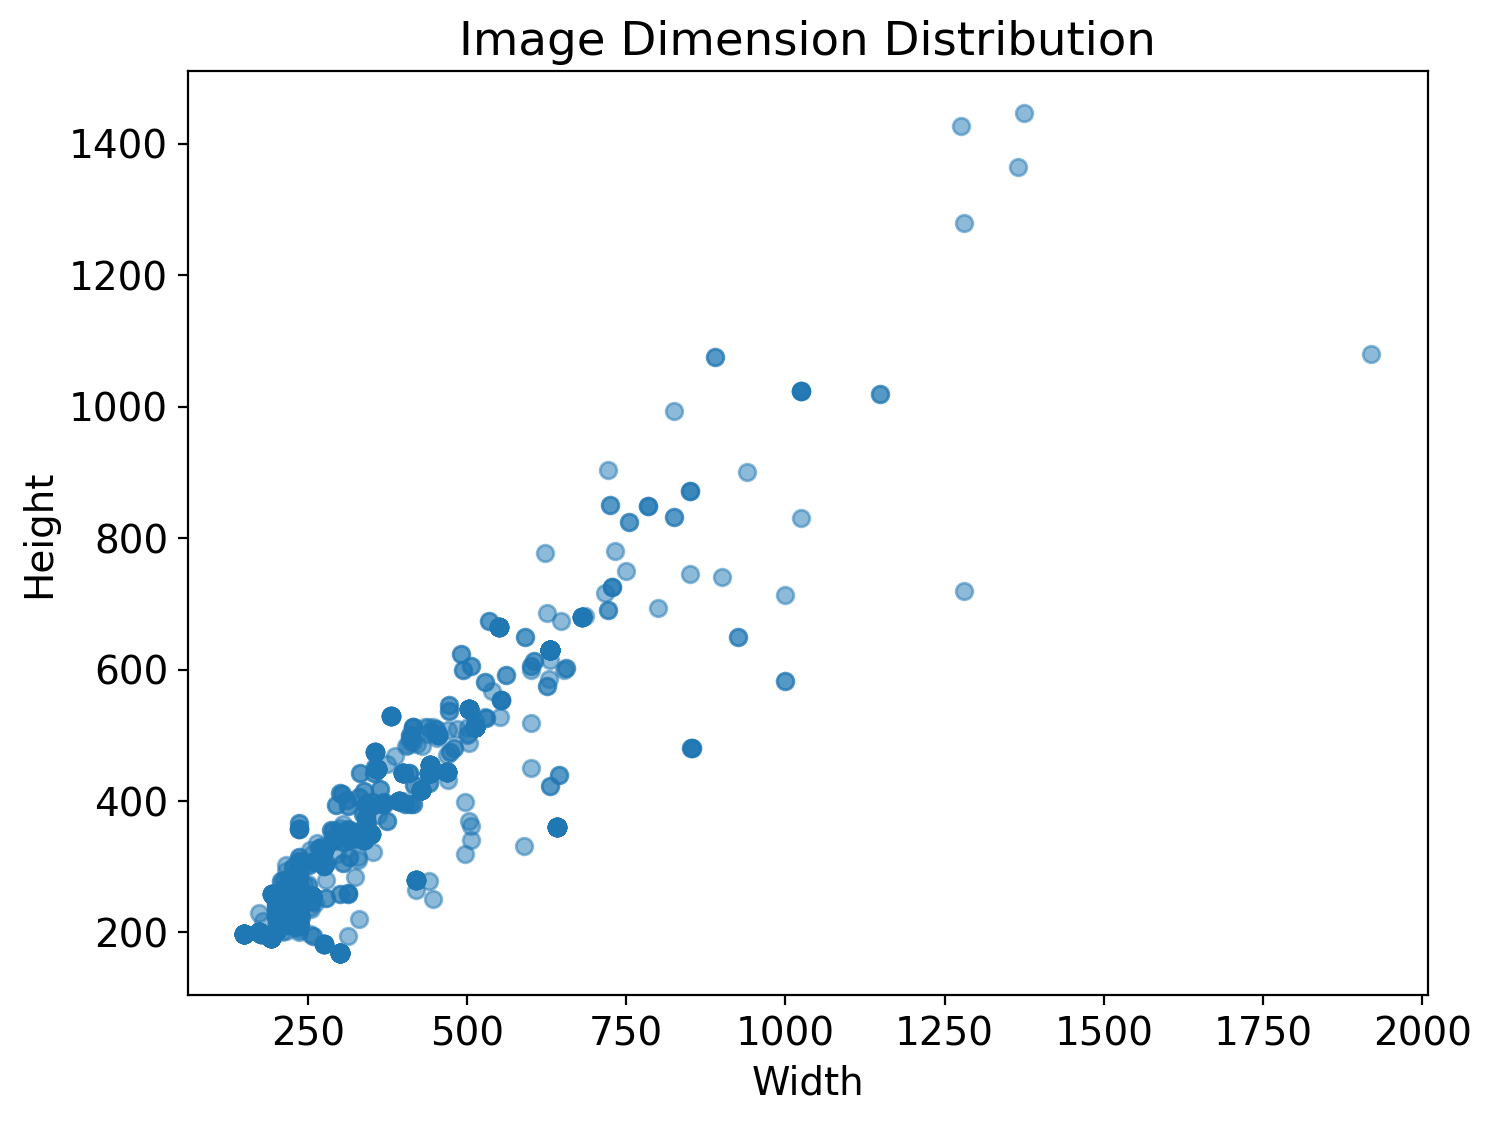

In [6]:
import pandas as pd

img_sizes = []
for path in train_paths + test_paths:
    img = Image.open(path)
    img_sizes.append(img.size)  # (width, height)

sizes_df = pd.DataFrame(img_sizes, columns=["Width", "Height"])
plt.figure(figsize=(8,6))
plt.scatter(sizes_df["Width"], sizes_df["Height"], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Dimension Distribution")
plt.show()


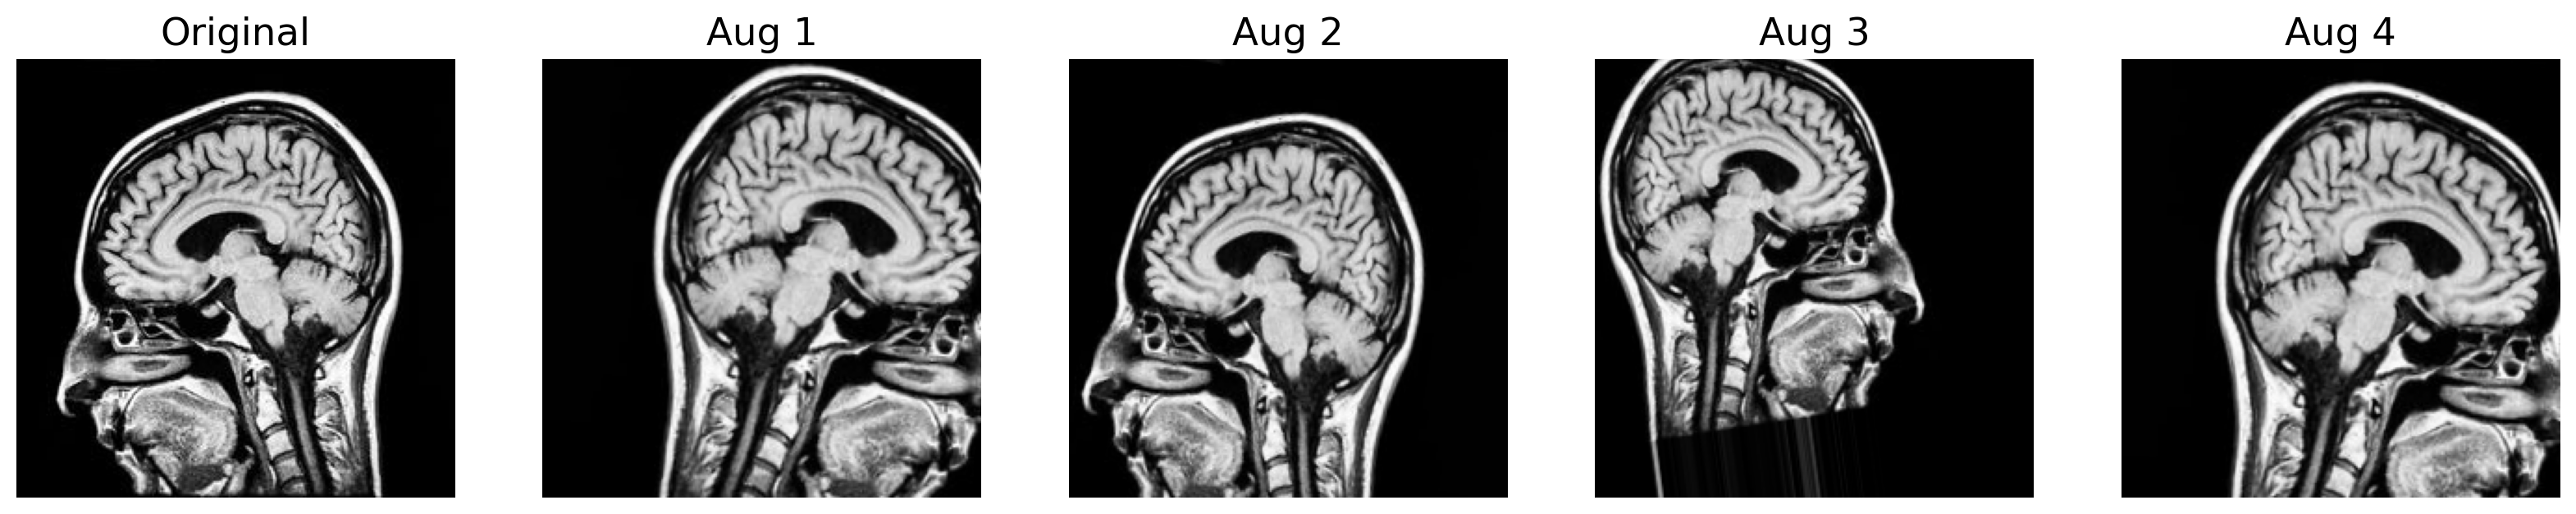

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                             width_shift_range=0.2, height_shift_range=0.2,
                             shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# Pick one image
img_path = train_paths[0]
img = Image.open(img_path)
x = np.expand_dims(np.array(img), 0)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
axes[0].imshow(img)
axes[0].set_title("Original")
axes[0].axis("off")

i = 1
for batch in datagen.flow(x, batch_size=1):
    axes[i].imshow(batch[0].astype('uint8'))
    axes[i].axis("off")
    axes[i].set_title(f"Aug {i}")
    i += 1
    if i == 5:
        break
plt.show()


# **Viewing Image**

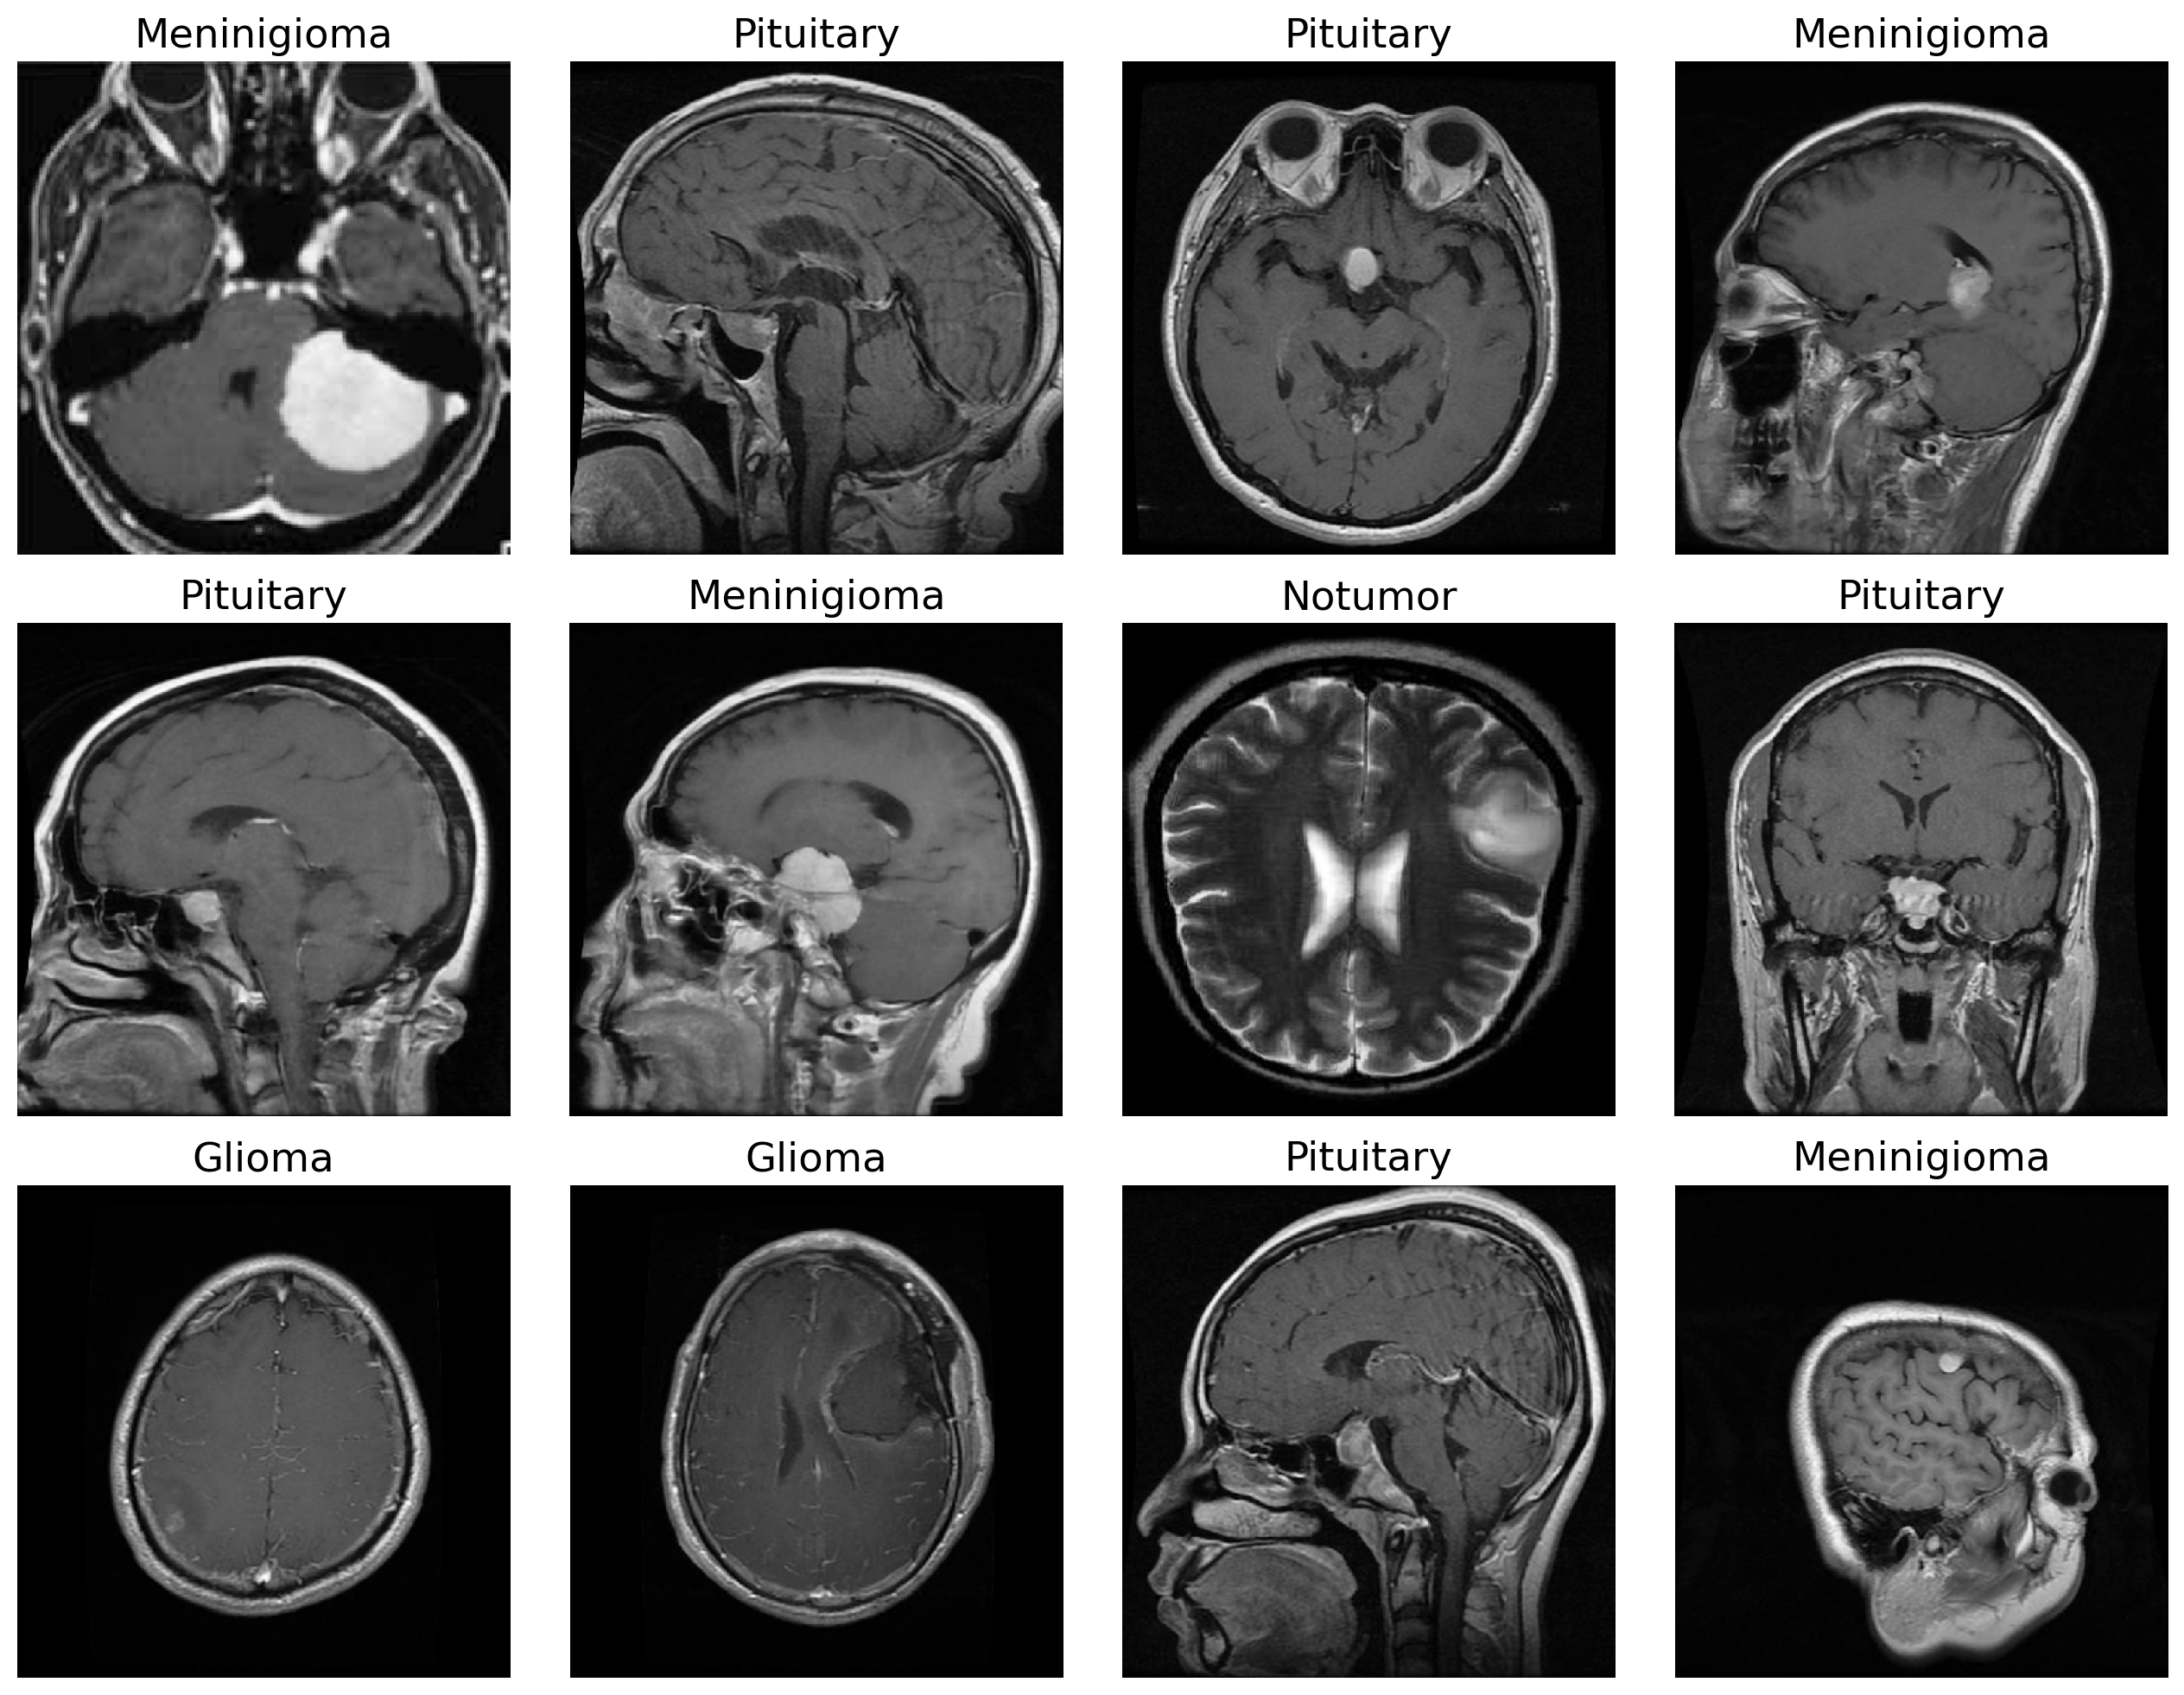

In [8]:
# Function to display a list of images without showing the index
def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=250, figsize=(12, 8)):

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size), color_mode='grayscale')
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(class_name)  # Display only class name
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage without showing index in the title
show_images(train_paths, train_index, class_mappings, im_size=350, figsize=(13, 10),
            index_list=range(100, 112))


# **Training**

# **Visualization of Augmanted images**

In [9]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    # RandomFlip("horizontal_and_vertical"),
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label

# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label

# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

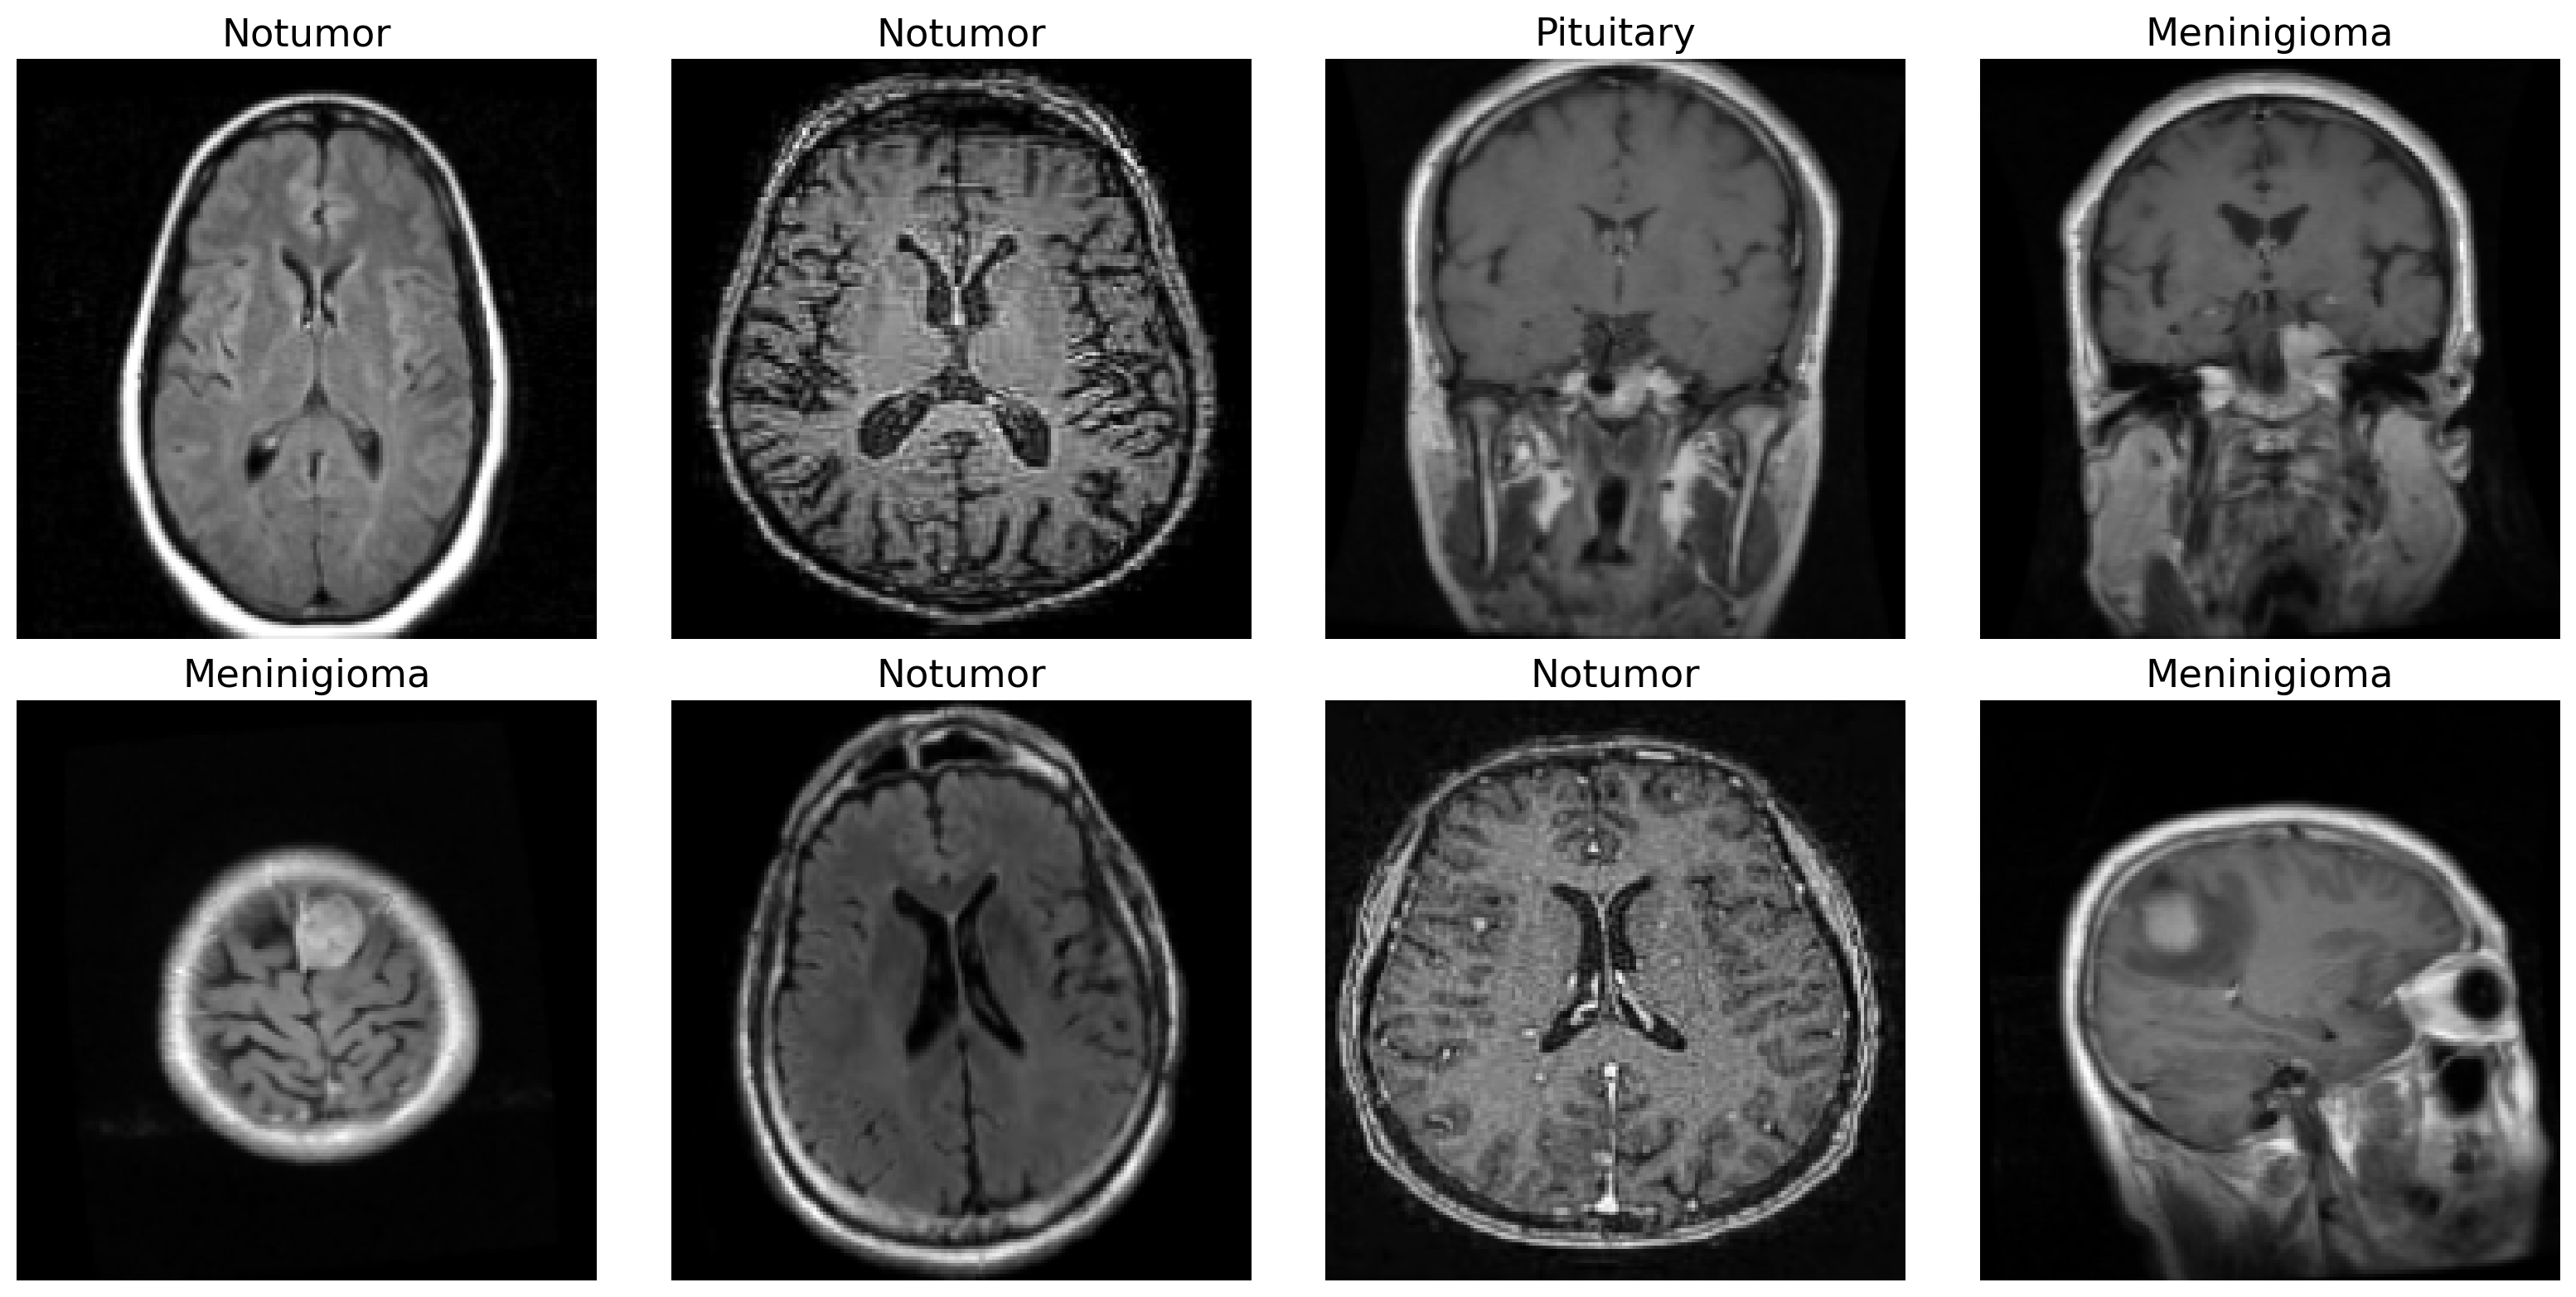

In [10]:
import matplotlib.pyplot as plt
import math

def show_augmented_from_pipeline(dataset, class_mappings, num_images=8, im_size=4):
    index_to_class = {v: k for k, v in class_mappings.items()}
    rows = math.ceil(num_images / 4)

    plt.figure(figsize=(im_size * 4, im_size * rows))
    for i, (images, labels) in enumerate(dataset.unbatch().shuffle(1000).take(num_images)):
        img = images.numpy()
        lbl = labels.numpy()
        class_name = index_to_class[lbl]

        ax = plt.subplot(rows, 4, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(class_name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


show_augmented_from_pipeline(train_ds_preprocessed, class_mappings, num_images=8)


# **Training**

In [11]:
# Classes and image shape
num_classes = len(class_mappings)
image_shape = (image_dim[0], image_dim[1], 1)

# Training parameters
epochs = 50
print(f"Number of Classes : {num_classes}")
print(f"Image Shape       : {image_shape}")
print(f"Epochs            : {epochs}")
print(f"Batch Size        : {batch_size}")

# One-hot encoding for labels
def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

# Apply label encoding to datasets
train_ds_preprocessed = train_ds_preprocessed.map(
    encode_labels, num_parallel_calls=tf.data.AUTOTUNE
)
test_ds_preprocessed = test_ds_preprocessed.map(
    encode_labels, num_parallel_calls=tf.data.AUTOTUNE
)


Number of Classes : 4
Image Shape       : (168, 168, 1)
Epochs            : 50
Batch Size        : 32


# **Building CNN Model**

In [12]:
# Building model
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 164, 164, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

In [13]:
# Custom callback for reducing learning rate at accuracy values
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [14]:
# Callbacks for improved covergence of gradient and best test accuracy
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50


I0000 00:00:1754618117.483722      96 service.cc:148] XLA service 0x7db350002800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754618117.484247      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754618117.905193      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/179 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2877 - loss: 1.3500

I0000 00:00:1754618120.803797      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.4859 - loss: 1.0917 - val_accuracy: 0.7101 - val_loss: 0.6897 - learning_rate: 0.0010
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7982 - loss: 0.5268 - val_accuracy: 0.7551 - val_loss: 0.6013 - learning_rate: 0.0010
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.8581 - loss: 0.3703 - val_accuracy: 0.7757 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8967 - loss: 0.2715 - val_accuracy: 0.8734 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9190 - loss: 0.2161 - val_accuracy: 0.9146 - val_loss: 0.2476 - learning_rate: 0.0010
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9411 - loss: 0.1642 - val_accuracy: 0.9458 - val_loss: 0.1639 - learning_rate: 0.0010
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.9499 - loss: 0.1372 - val

# **Model Evaluation**

In [15]:
model.save('/kaggle/working/brain_tumor_model.h5')
model.save('/kaggle/working/brain_tumor_model.keras')

In [29]:
# Loading saved model
model = load_model('model.keras')

# Evaluate model and test data accuracy
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9907 - loss: 0.0778
Test accuracy: 99.2372%


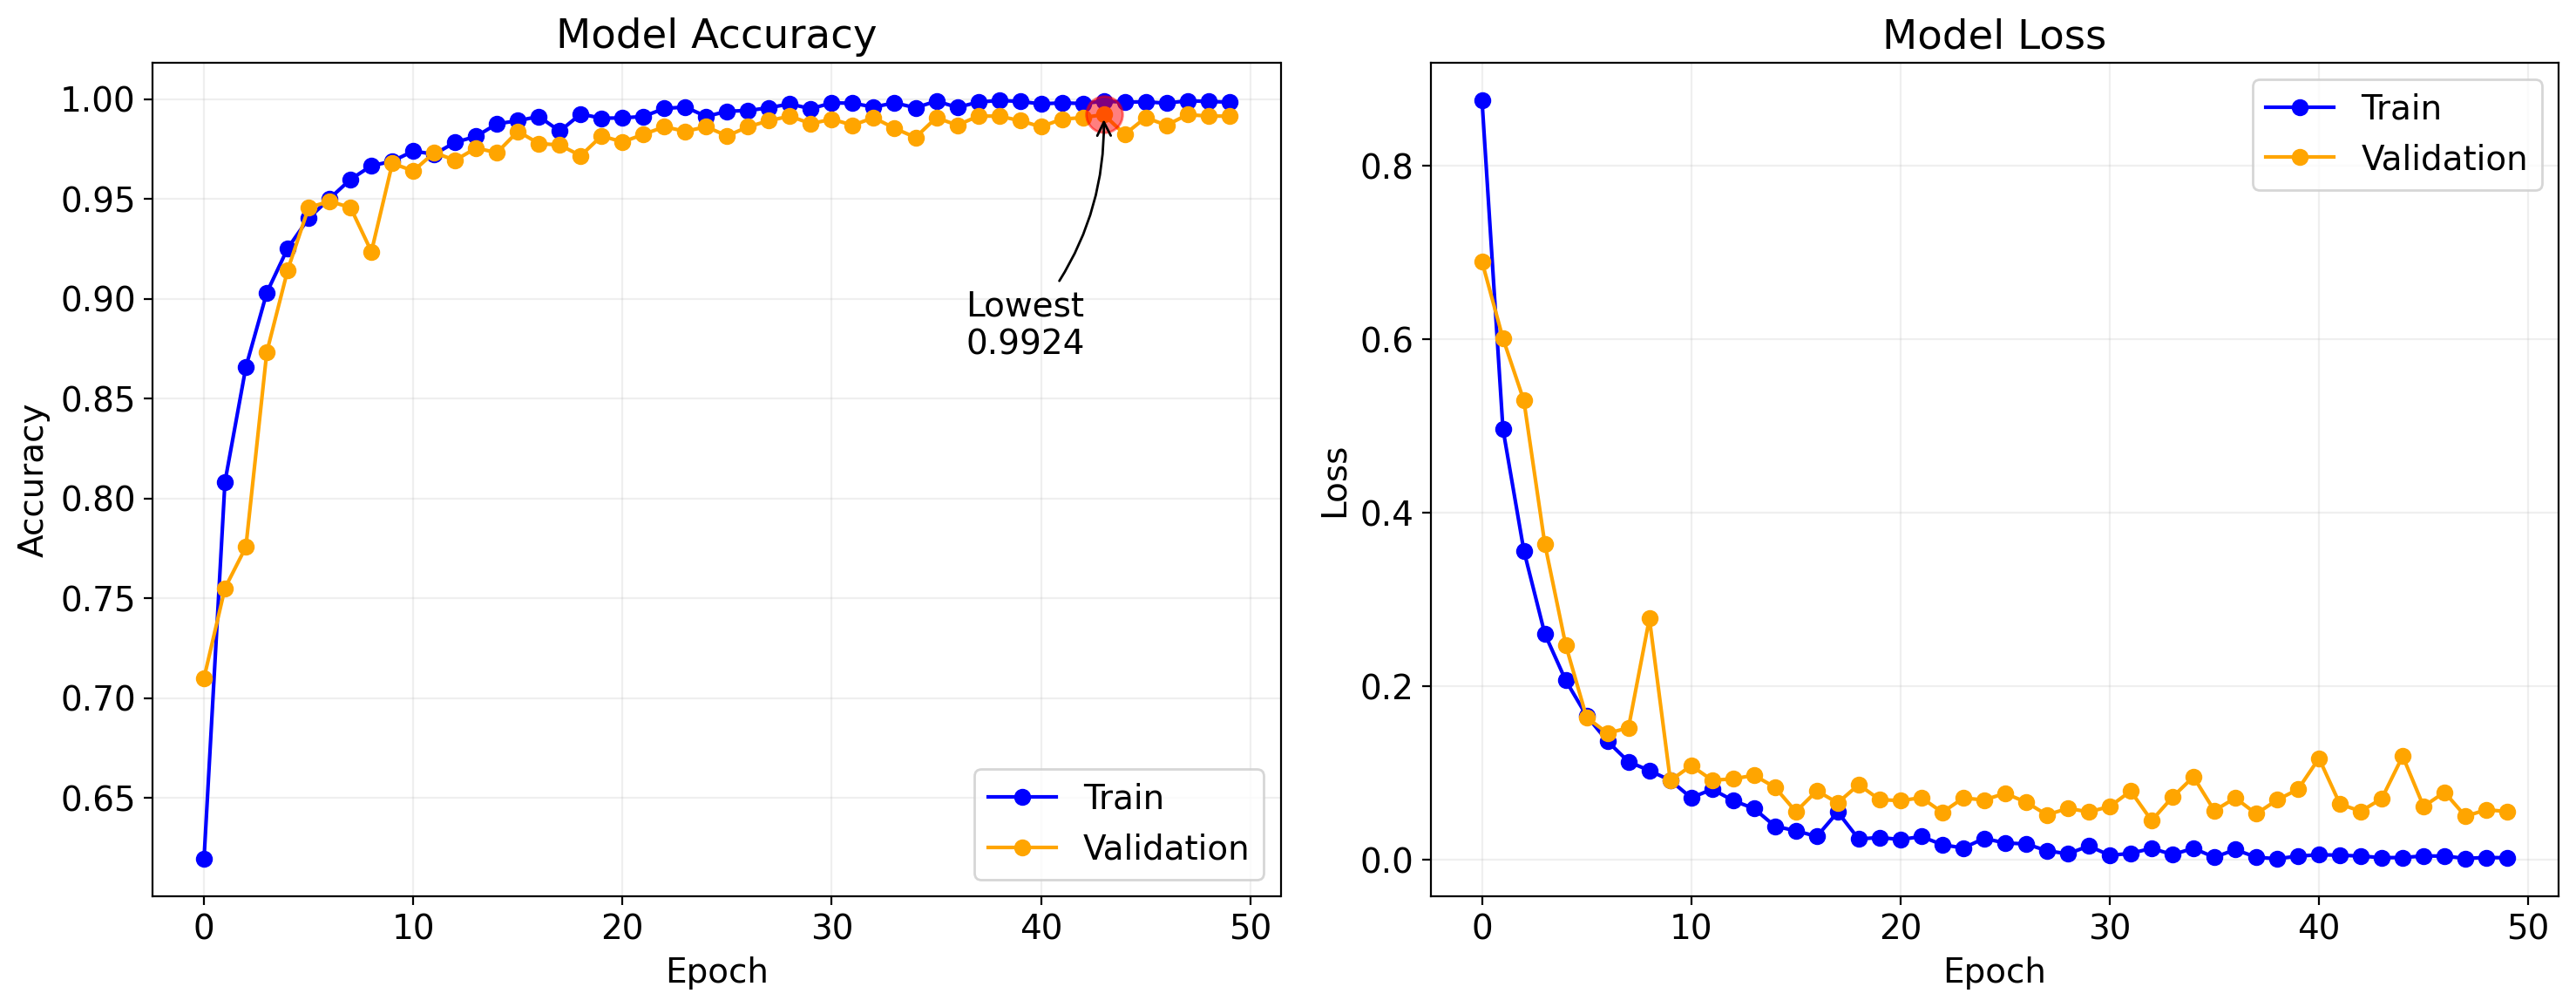

In [17]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history.history['val_accuracy'])
min_val_acc = np.max(history.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc),
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

In [18]:
# Using test data for true and preductions
true_labels = []
predicted_labels = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy())
    true_labels.append(true_label)

    # Get model prediction (Predict expects batch dimension)
    pred = model.predict(tf.expand_dims(images, 0), verbose=False)
    predicted_label = np.argmax(pred)
    predicted_labels.append(predicted_label)

In [19]:
def plot_confusion_matrix(true_labels, predicted_labels, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

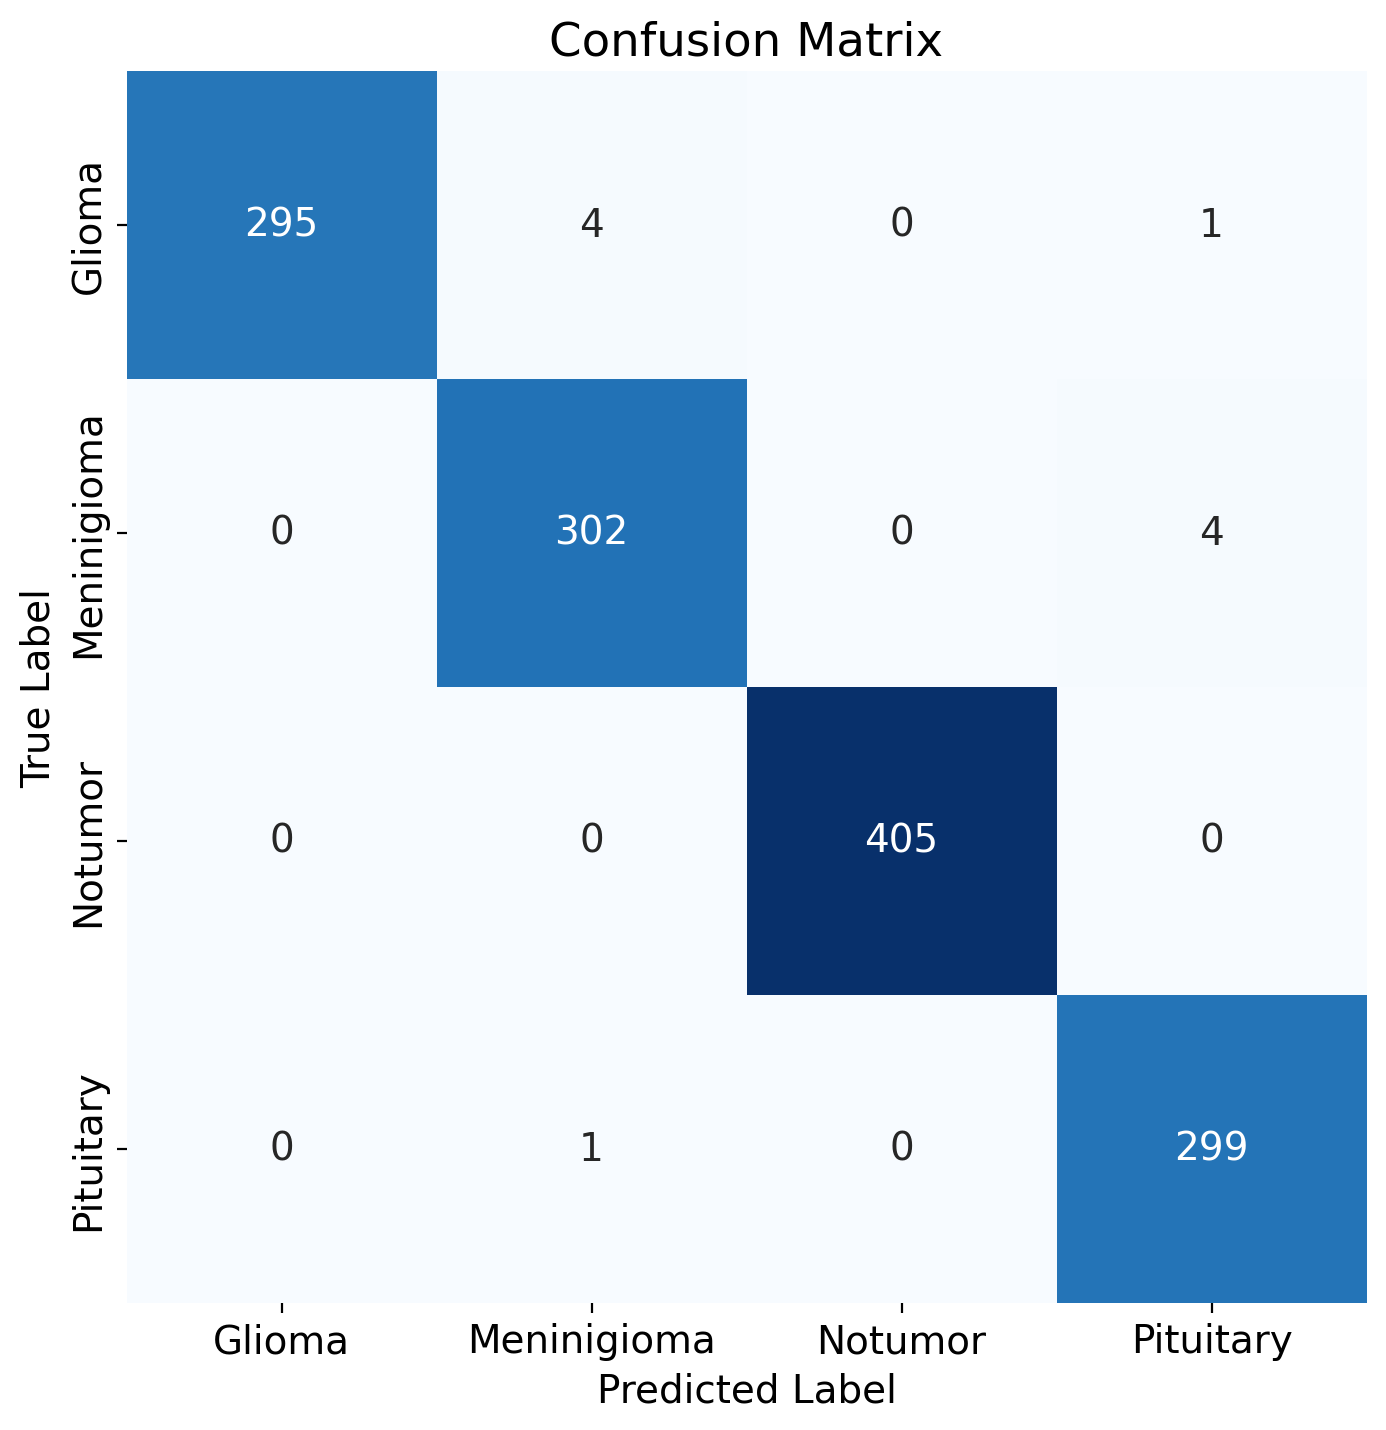

Class-wise metrics:
Class: Glioma
Precision: 1.0000
Recall: 0.9833
F1-Score: 0.9916

Class: Meninigioma
Precision: 0.9837
Recall: 0.9869
F1-Score: 0.9853

Class: Notumor
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Class: Pituitary
Precision: 0.9836
Recall: 0.9967
F1-Score: 0.9901

Overall Accuracy: 0.9924


In [20]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels,
                      predicted_labels,
                      class_mappings,
                      metrics=True)

In [21]:
def plot_sample_predictions(model, dataset, index_to_class, num_samples=9, figsize=(13, 12)):
    plt.figure(figsize=figsize)
    num_rows = num_cols = int(np.sqrt(num_samples))

    iterator = iter(dataset.unbatch())

    for i in range(1, num_samples + 1):
        image, true_label = next(iterator)
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]

        true_class_index = np.argmax(true_label.numpy())
        true_class = index_to_class[true_class_index]
        predicted_class = index_to_class[predicted_label]

        # Determine title color based on prediction accuracy
        title_color = 'green' if true_class_index == predicted_label else 'red'

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

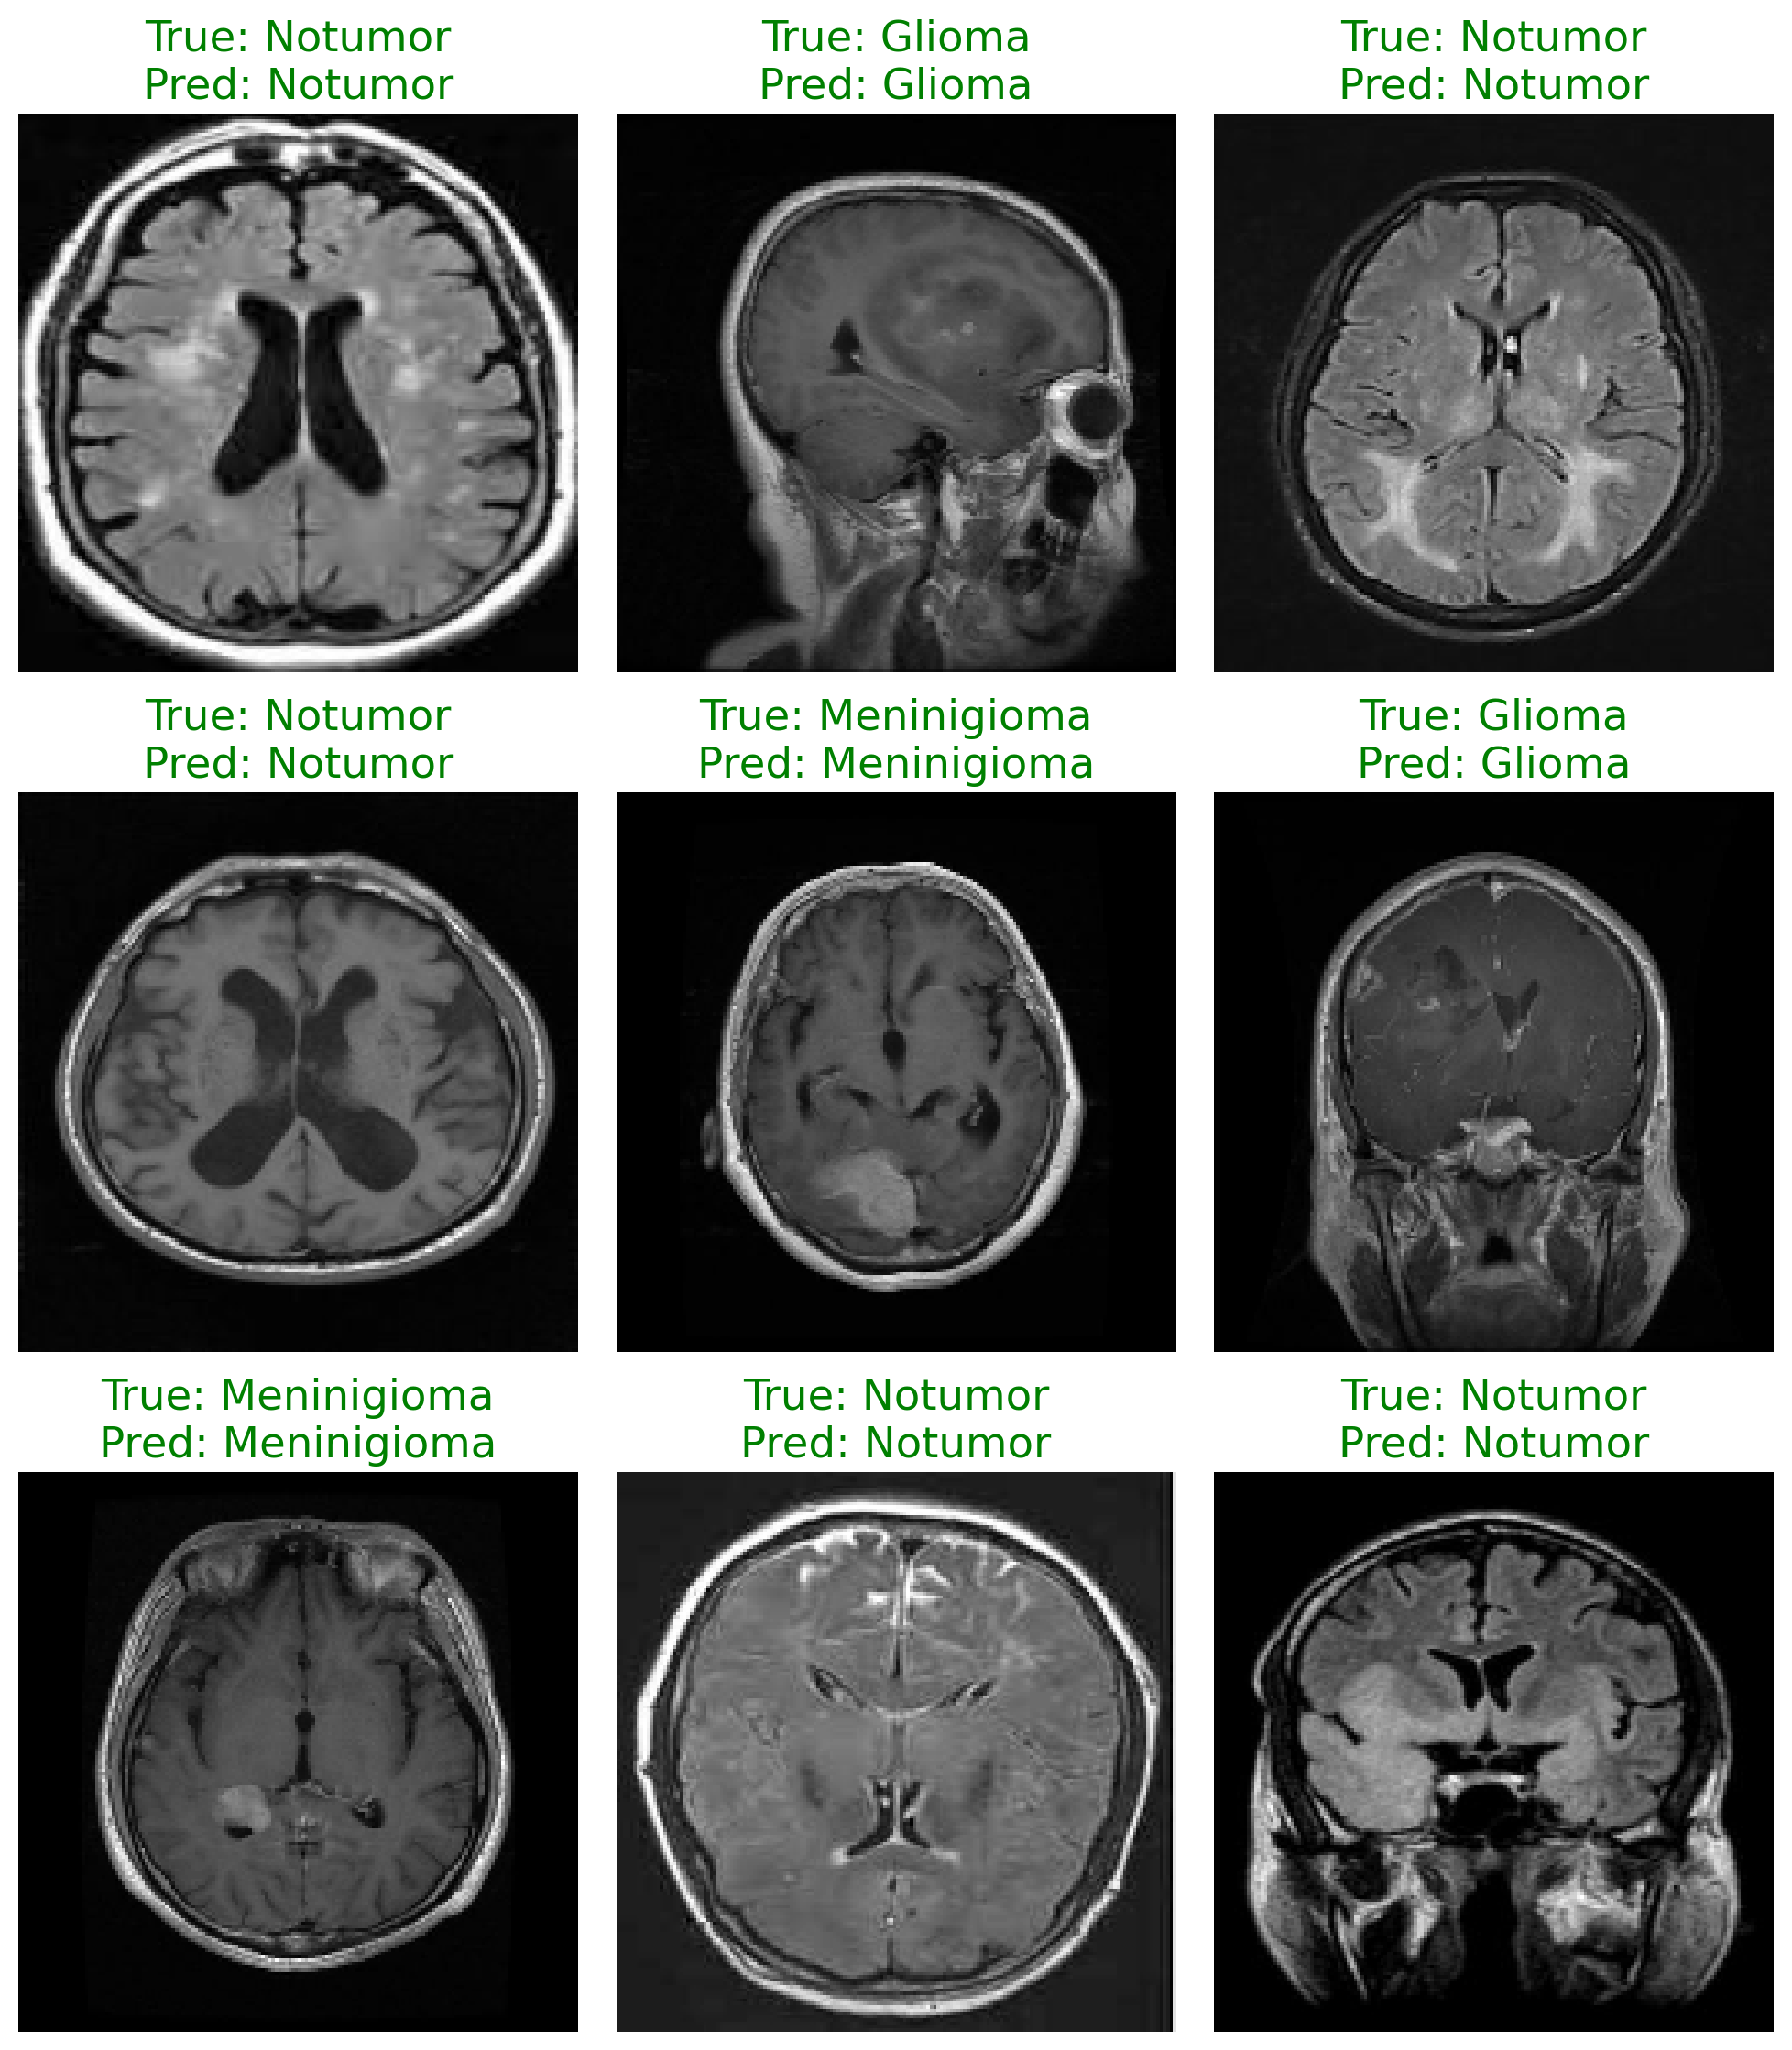

In [22]:
# Plottinng samples with predictions
plot_sample_predictions(model=model,
                        dataset=test_ds_preprocessed,
                        index_to_class=inv_class_mappings,
                        num_samples=9,
                        figsize=(10, 11.5))

# **Misclassified Tumor**

In [23]:
def plot_misclassified_samples(model, dataset, index_to_class, figsize=(10, 10)):
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    # Iterate over dataset to collect misclassified images
    for image, true_label in dataset.unbatch():
        image_batch = tf.expand_dims(image, 0)
        predictions = model.predict(image_batch, verbose=False)
        predicted_label = np.argmax(predictions, axis=1)[0]
        true_class_index = np.argmax(true_label.numpy())

        if true_class_index != predicted_label:
            misclassified_images.append(image.numpy().squeeze())
            misclassified_labels.append(index_to_class[true_class_index])
            misclassified_predictions.append(index_to_class[predicted_label])

    # Determine number of rows and columns for subplot
    num_misclassified = len(misclassified_images)
    cols = int(np.sqrt(num_misclassified)) + 1
    rows = num_misclassified // cols + (num_misclassified % cols > 0)

    # Plotting misclassified images
    miss_classified_zip = zip(misclassified_images, misclassified_labels, misclassified_predictions)
    plt.figure(figsize=figsize)
    for i, (image, true_label, predicted_label) in enumerate(miss_classified_zip):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

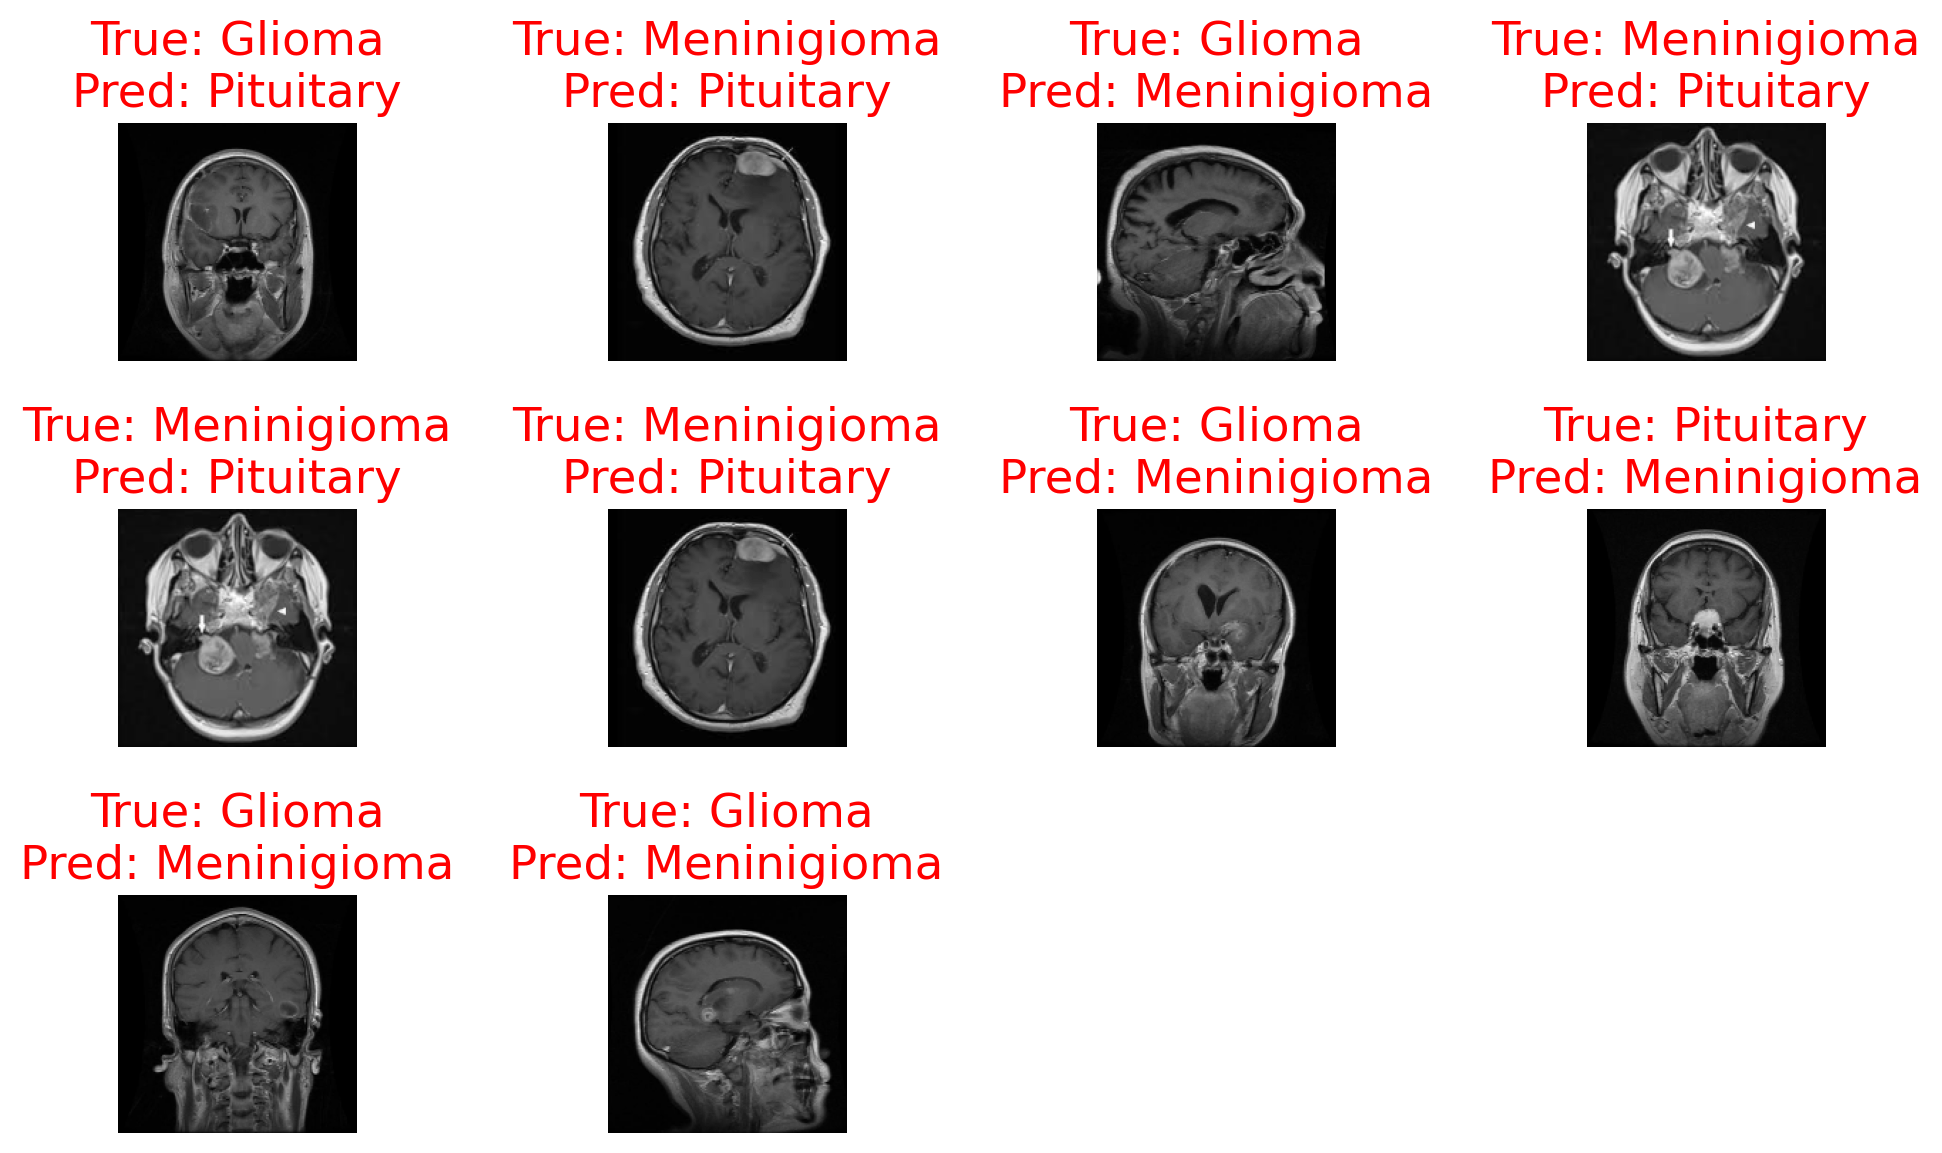

In [24]:
# Plotting misclassified images
plot_misclassified_samples(
    model=model,
    dataset=test_ds_preprocessed,
    index_to_class=inv_class_mappings,
    figsize=(10, 6)
)

# **Testing on new Data**

In [25]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_path, image_shape=(168, 168)):
    img = image.load_img(image_path, target_size=image_shape, color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add the batch dimension
    return img_array

# Function to display a row of images with predictions
def display_images_and_predictions(image_paths, predictions, true_labels, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    for i, (image_path, prediction, true_label) in enumerate(zip(image_paths, predictions, true_labels)):
        ax = plt.subplot(1, len(image_paths), i + 1)
        img_array = load_and_preprocess_image(image_path)
        img_array = np.squeeze(img_array)
        plt.imshow(img_array, cmap='gray')
        title_color = 'green' if prediction == true_label else 'red'
        plt.title(f'True Label: {true_label}\nPred: {prediction}', color=title_color)
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Class Mappings: {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}

Normal Image Prediction: [0. 0. 1. 0.]
Glioma Image Prediction: [1. 0. 0. 0.]
Meningioma Image Prediction: [0. 1. 0. 0.]
Pituitary Image Prediction: [0. 0. 0. 1.]


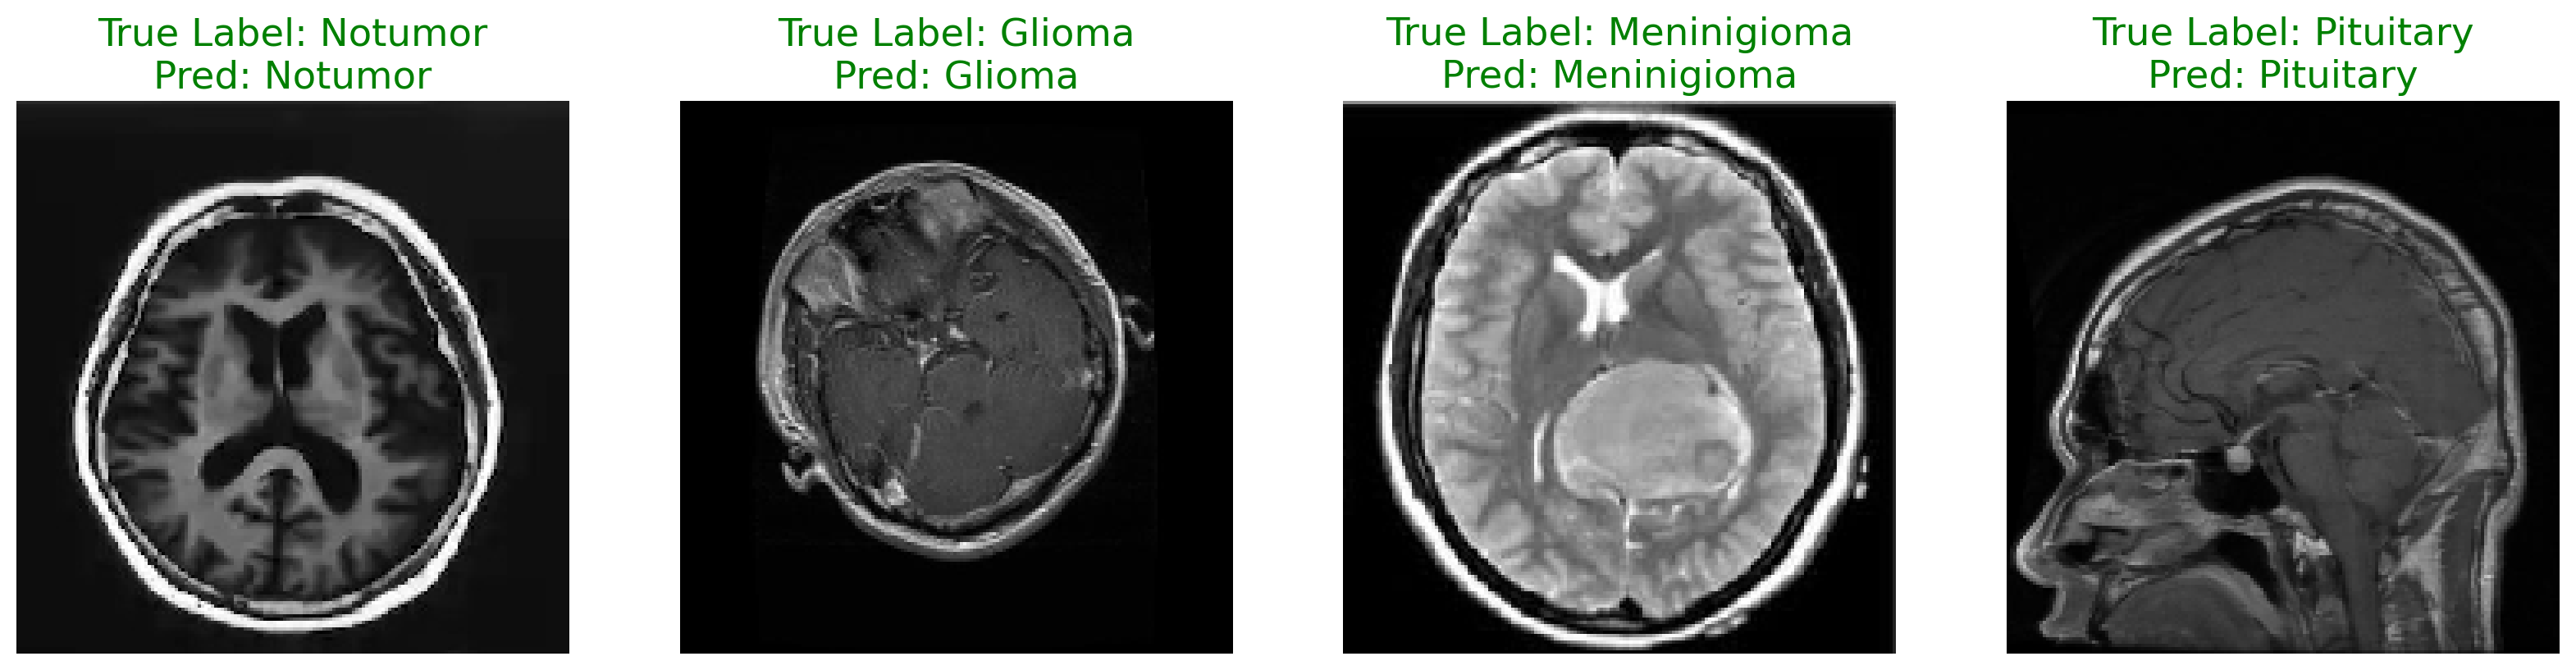

In [27]:
# Load and preprocess the images
normal_image_path = '/kaggle/input/brain-tumor-dataset/Testing/notumor/Te-noTr_0003.jpg'
glioma_image_path = '/kaggle/input/brain-tumor-dataset/Testing/glioma/Te-glTr_0006.jpg'
meningioma_image_path = '/kaggle/input/brain-tumor-dataset/Testing/meningioma/Te-meTr_0006.jpg'
pituitary_tumor_path = '/kaggle/input/brain-tumor-dataset/Testing/pituitary/Te-piTr_0006.jpg'

# Image paths
image_paths = [
    normal_image_path,
    glioma_image_path,
    meningioma_image_path,
    pituitary_tumor_path
]

# True labels for images
true_labels = ['Notumor', 'Glioma', 'Meninigioma', 'Pituitary']

# Load and preprocess images, then make predictions
images = [load_and_preprocess_image(path) for path in image_paths]
predictions = [model.predict(image) for image in images]

# Determine the predicted labels
predicted_labels = [inv_class_mappings[np.argmax(one_hot)] for one_hot in predictions]

# Output the predictions
print(f'Class Mappings: {class_mappings}')
print("\nNormal Image Prediction:", np.round(predictions[0], 3)[0])
print("Glioma Image Prediction:", np.round(predictions[1], 3)[0])
print("Meningioma Image Prediction:", np.round(predictions[2], 3)[0])
print("Pituitary Image Prediction:", np.round(predictions[3], 3)[0])

# Display images with predictions
display_images_and_predictions(image_paths, predicted_labels, true_labels)